In [ ]:
# default_exp instance_segmentation

# 1. Challenge: dolphin instance segmentation model

> The goal of this challenge is to find all instances of dolphins in a picture and then color pixes of each dolphin with a unique color.

## Introduction and motivation

Fill in please

In [ ]:
# export

from pathlib import Path
from typing import List, Tuple, Union, Optional, Dict, Set

In [ ]:
# exporti

import numpy as np
import os
from datetime import datetime
import torch
import torch.utils.data
from torch.hub import download_url_to_file
import torchvision
import PIL
from PIL import Image
from zipfile import ZipFile

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

for m in [np, torch, torchvision, PIL]:
    print(f"{m.__name__:12}: {m.__version__}")

numpy       : 1.18.5
torch       : 1.7.1
torchvision : 0.8.2
PIL         : 7.2.0


## Download data

We start by downloading and visualizing the dataset containing 200 photographs with one or more dolphins split into a training set containing 160 photographs and a validation set containing 40 photographs.

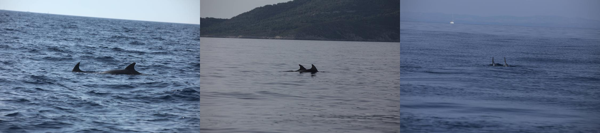

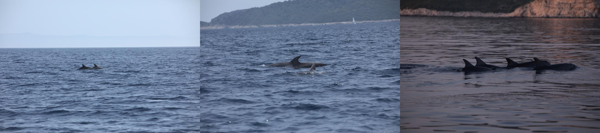

In [ ]:
from dolphins_recognition_challenge.datasets import get_dataset, display_batches
    
data_loader, data_loader_test = get_dataset("segmentation", batch_size=3)

display_batches(data_loader, n_batches=2, width=600)

## Data augmentation

In order to prevent overfitting which happens when the dataset size is too small, we perform a number of transformations to increase the size of the dataset. One transofrmation implemented in the Torch vision library is `RandomHorizontalFlip` and we will implemented `MyColorJitter` which is basically just a wrapper around `torchvision.transforms.ColorJitter` class. However, we cannot use this class directly without a wrapper because a transofrmation could possibly affect targets and not just the image. For example, if we were to implement RandomCrop, we would need to crop segmentation masks and readjust bounding boxes as well.

In [ ]:
class MyColorJitter:
    def __init__(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        self.torch_color_jitter = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue
        )

    def __call__(self, image, target):
        image = self.torch_color_jitter(image)
        return image, target

We will make a series of transformations on an image and we will combine all those transofrmations in a single one as follows:

In [ ]:
import transforms as T

def get_tensor_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(
            MyColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
        )
        transforms.append(T.RandomHorizontalFlip(0.5))
        # TODO: add additional transforms: e.g. random crop
    return T.Compose(transforms)

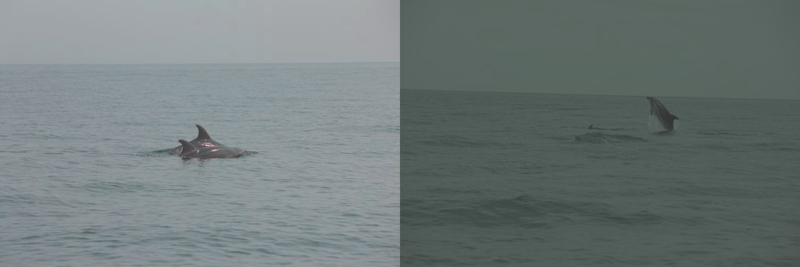

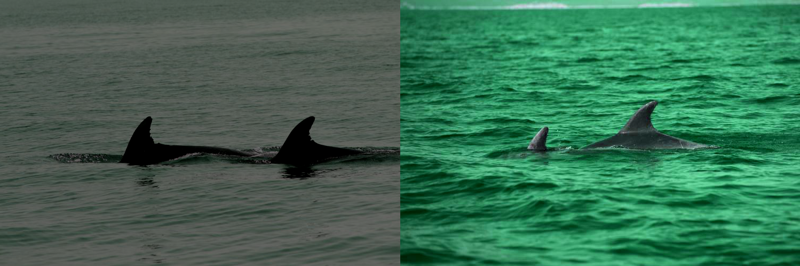

In [ ]:
data_loader, data_loader_test = get_dataset("segmentation", batch_size=2, get_tensor_transforms=get_tensor_transforms)

display_batches(data_loader, n_batches=2, width=800)

With data augementation defined, we are ready to generate the actual datasets used for training our models.

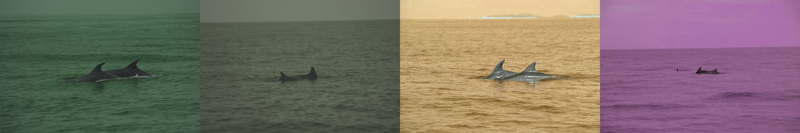

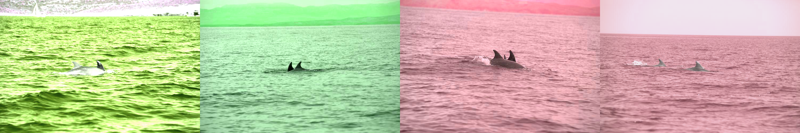

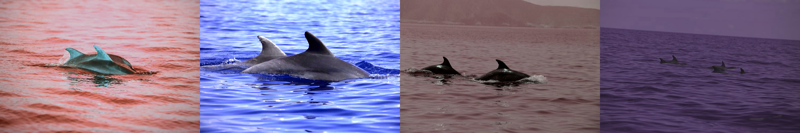

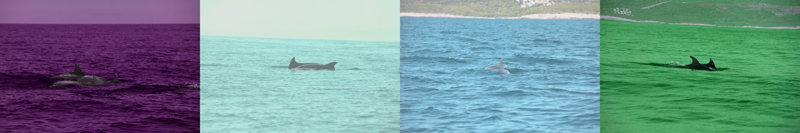

In [ ]:
batch_size = 4

data_loader, data_loader_test = get_dataset(
    "segmentation", get_tensor_transforms=get_tensor_transforms, batch_size=batch_size
)

display_batches(data_loader, n_batches=4, width=800)

> Tip: incorporate more transformation classes such as RandomCrop etc. (https://pytorch.org/docs/stable/torchvision/transforms.html)

## Model

In [ ]:
def get_instance_segmentation_model(hidden_layer_size):
    # our dataset has two classes only - background and dolphin    
    num_classes = 2
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True
    )  # box_score_thresh=0.5

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_channels=in_features_mask, 
        dim_reduced=hidden_layer_size,
        num_classes=num_classes
    )

    return model

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer_size=256)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
# slow

from traceback_with_variables import printing_tb

from engine import train_one_epoch, evaluate

# let's train it for 20 epochs
num_epochs = 20

print("Training...")
with printing_tb():
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/40]  eta: 0:00:51  lr: 0.000133  loss: 3.8964 (3.8964)  loss_classifier: 0.9773 (0.9773)  loss_box_reg: 0.2797 (0.2797)  loss_mask: 2.5986 (2.5986)  loss_objectness: 0.0113 (0.0113)  loss_rpn_box_reg: 0.0295 (0.0295)  time: 1.2918  data: 0.7365  max mem: 4477
Epoch: [0]  [10/40]  eta: 0:00:16  lr: 0.001414  loss: 1.3453 (2.1033)  loss_classifier: 0.2631 (0.4807)  loss_box_reg: 0.2872 (0.2843)  loss_mask: 0.7485 (1.2939)  loss_objectness: 0.0135 (0.0278)  loss_rpn_box_reg: 0.0095 (0.0166)  time: 0.5513  data: 0.0742  max mem: 5189
Epoch: [0]  [20/40]  eta: 0:00:10  lr: 0.002695  loss: 1.0537 (1.5074)  loss_classifier: 0.2357 (0.3438)  loss_box_reg: 0.2662 (0.2664)  loss_mask: 0.4620 (0.8403)  loss_objectness: 0.0258 (0.0356)  loss_rpn_box_reg: 0.0098 (0.0215)  time: 0.4777  data: 0.0080  max mem: 5189
Epoch: [0]  [30/40]  eta: 0:00:05  lr: 0.003975  loss: 0.6962 (1.2475)  loss_classifier: 0.1226 (0.2692)  loss_box_reg: 0.2354 (0.2580)  loss_mask: 0.2537 (0.6471)  loss_ob

Epoch: [2]  [20/40]  eta: 0:00:11  lr: 0.005000  loss: 0.4084 (0.4441)  loss_classifier: 0.0575 (0.0700)  loss_box_reg: 0.1345 (0.1506)  loss_mask: 0.1856 (0.1862)  loss_objectness: 0.0044 (0.0092)  loss_rpn_box_reg: 0.0075 (0.0280)  time: 0.5348  data: 0.0085  max mem: 5189
Epoch: [2]  [30/40]  eta: 0:00:05  lr: 0.005000  loss: 0.4422 (0.4608)  loss_classifier: 0.0809 (0.0759)  loss_box_reg: 0.1508 (0.1583)  loss_mask: 0.1871 (0.1896)  loss_objectness: 0.0069 (0.0104)  loss_rpn_box_reg: 0.0108 (0.0265)  time: 0.5550  data: 0.0071  max mem: 5189
Epoch: [2]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.4422 (0.4476)  loss_classifier: 0.0846 (0.0742)  loss_box_reg: 0.1623 (0.1573)  loss_mask: 0.1801 (0.1841)  loss_objectness: 0.0056 (0.0091)  loss_rpn_box_reg: 0.0105 (0.0228)  time: 0.5611  data: 0.0068  max mem: 5189
Epoch: [2] Total time: 0:00:22 (0.5657 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:08  model_time: 0.2534 (0.2534)  evaluator_time: 0.0418 (0.0418)  

Epoch: [4]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.3464 (0.3525)  loss_classifier: 0.0532 (0.0554)  loss_box_reg: 0.1089 (0.1143)  loss_mask: 0.1521 (0.1550)  loss_objectness: 0.0038 (0.0042)  loss_rpn_box_reg: 0.0119 (0.0236)  time: 0.5813  data: 0.0081  max mem: 5189
Epoch: [4] Total time: 0:00:23 (0.5878 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:08  model_time: 0.2599 (0.2599)  evaluator_time: 0.0443 (0.0443)  time: 0.8043  data: 0.4971  max mem: 5189
Test:  [ 9/10]  eta: 0:00:00  model_time: 0.2221 (0.2264)  evaluator_time: 0.0369 (0.0378)  time: 0.3219  data: 0.0545  max mem: 5189
Test: Total time: 0:00:03 (0.3277 s / it)
Averaged stats: model_time: 0.2221 (0.2264)  evaluator_time: 0.0369 (0.0378)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

Test:  [ 9/10]  eta: 0:00:00  model_time: 0.2063 (0.2121)  evaluator_time: 0.0219 (0.0236)  time: 0.2945  data: 0.0560  max mem: 5189
Test: Total time: 0:00:03 (0.3013 s / it)
Averaged stats: model_time: 0.2063 (0.2121)  evaluator_time: 0.0219 (0.0236)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 1

Epoch: [9]  [ 0/40]  eta: 0:00:49  lr: 0.005000  loss: 0.3162 (0.3162)  loss_classifier: 0.0453 (0.0453)  loss_box_reg: 0.1101 (0.1101)  loss_mask: 0.1526 (0.1526)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0068 (0.0068)  time: 1.2318  data: 0.7385  max mem: 5190
Epoch: [9]  [10/40]  eta: 0:00:18  lr: 0.005000  loss: 0.2456 (0.2637)  loss_classifier: 0.0376 (0.0348)  loss_box_reg: 0.0793 (0.0794)  loss_mask: 0.1217 (0.1348)  loss_objectness: 0.0016 (0.0020)  loss_rpn_box_reg: 0.0034 (0.0127)  time: 0.6246  data: 0.0730  max mem: 5190
Epoch: [9]  [20/40]  eta: 0:00:12  lr: 0.005000  loss: 0.2418 (0.2679)  loss_classifier: 0.0351 (0.0346)  loss_box_reg: 0.0713 (0.0750)  loss_mask: 0.1196 (0.1299)  loss_objectness: 0.0017 (0.0020)  loss_rpn_box_reg: 0.0049 (0.0264)  time: 0.5792  data: 0.0071  max mem: 5190
Epoch: [9]  [30/40]  eta: 0:00:06  lr: 0.005000  loss: 0.2936 (0.2858)  loss_classifier: 0.0425 (0.0390)  loss_box_reg: 0.0975 (0.0865)  loss_mask: 0.1332 (0.1365)  loss_ob

Epoch: [11]  [20/40]  eta: 0:00:12  lr: 0.000500  loss: 0.2174 (0.2293)  loss_classifier: 0.0291 (0.0326)  loss_box_reg: 0.0588 (0.0660)  loss_mask: 0.1240 (0.1237)  loss_objectness: 0.0008 (0.0011)  loss_rpn_box_reg: 0.0038 (0.0059)  time: 0.5906  data: 0.0080  max mem: 5190
Epoch: [11]  [30/40]  eta: 0:00:06  lr: 0.000500  loss: 0.2337 (0.2476)  loss_classifier: 0.0312 (0.0350)  loss_box_reg: 0.0716 (0.0697)  loss_mask: 0.1262 (0.1259)  loss_objectness: 0.0008 (0.0019)  loss_rpn_box_reg: 0.0041 (0.0151)  time: 0.6069  data: 0.0079  max mem: 5190
Epoch: [11]  [39/40]  eta: 0:00:00  lr: 0.000500  loss: 0.2337 (0.2495)  loss_classifier: 0.0383 (0.0353)  loss_box_reg: 0.0788 (0.0721)  loss_mask: 0.1262 (0.1265)  loss_objectness: 0.0013 (0.0022)  loss_rpn_box_reg: 0.0043 (0.0135)  time: 0.6157  data: 0.0077  max mem: 5190
Epoch: [11] Total time: 0:00:24 (0.6188 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:07  model_time: 0.2466 (0.2466)  evaluator_time: 0.0265 (0.026

Epoch: [13]  [39/40]  eta: 0:00:00  lr: 0.000500  loss: 0.2674 (0.2471)  loss_classifier: 0.0375 (0.0338)  loss_box_reg: 0.0769 (0.0716)  loss_mask: 0.1261 (0.1266)  loss_objectness: 0.0019 (0.0022)  loss_rpn_box_reg: 0.0061 (0.0129)  time: 0.6152  data: 0.0077  max mem: 5190
Epoch: [13] Total time: 0:00:24 (0.6218 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:07  model_time: 0.2262 (0.2262)  evaluator_time: 0.0280 (0.0280)  time: 0.7557  data: 0.4983  max mem: 5190
Test:  [ 9/10]  eta: 0:00:00  model_time: 0.2076 (0.2100)  evaluator_time: 0.0208 (0.0223)  time: 0.2903  data: 0.0550  max mem: 5190
Test: Total time: 0:00:02 (0.2967 s / it)
Averaged stats: model_time: 0.2076 (0.2100)  evaluator_time: 0.0208 (0.0223)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Test:  [ 9/10]  eta: 0:00:00  model_time: 0.2057 (0.2090)  evaluator_time: 0.0199 (0.0207)  time: 0.2904  data: 0.0577  max mem: 5190
Test: Total time: 0:00:02 (0.2961 s / it)
Averaged stats: model_time: 0.2057 (0.2090)  evaluator_time: 0.0199 (0.0207)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 1

Epoch: [18]  [ 0/40]  eta: 0:00:49  lr: 0.000500  loss: 0.1389 (0.1389)  loss_classifier: 0.0246 (0.0246)  loss_box_reg: 0.0311 (0.0311)  loss_mask: 0.0781 (0.0781)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 1.2488  data: 0.7533  max mem: 5190
Epoch: [18]  [10/40]  eta: 0:00:19  lr: 0.000500  loss: 0.2122 (0.2432)  loss_classifier: 0.0293 (0.0333)  loss_box_reg: 0.0531 (0.0733)  loss_mask: 0.1174 (0.1266)  loss_objectness: 0.0021 (0.0023)  loss_rpn_box_reg: 0.0070 (0.0077)  time: 0.6452  data: 0.0741  max mem: 5190
Epoch: [18]  [20/40]  eta: 0:00:12  lr: 0.000500  loss: 0.2122 (0.2323)  loss_classifier: 0.0280 (0.0325)  loss_box_reg: 0.0610 (0.0694)  loss_mask: 0.1146 (0.1224)  loss_objectness: 0.0010 (0.0017)  loss_rpn_box_reg: 0.0029 (0.0062)  time: 0.5998  data: 0.0067  max mem: 5190
Epoch: [18]  [30/40]  eta: 0:00:06  lr: 0.000500  loss: 0.2194 (0.2341)  loss_classifier: 0.0324 (0.0323)  loss_box_reg: 0.0615 (0.0663)  loss_mask: 0.1136 (0.1208)  los

In [ ]:
# skip
# pick one image from the test set
img, _ = data_loader_test.dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
prediction

[{'boxes': tensor([[296.2079, 193.3952, 453.0812, 267.1093],
          [442.2224, 187.0209, 616.6365, 252.8787],
          [295.5228, 212.7988, 341.5661, 258.0097],
          [295.8234, 197.4667, 370.7387, 262.2480],
          [369.6344, 216.4189, 417.1077, 230.0708],
          [326.0764, 192.2509, 429.9577, 242.1528]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9996, 0.9995, 0.9818, 0.2625, 0.2471, 0.2113], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0., 

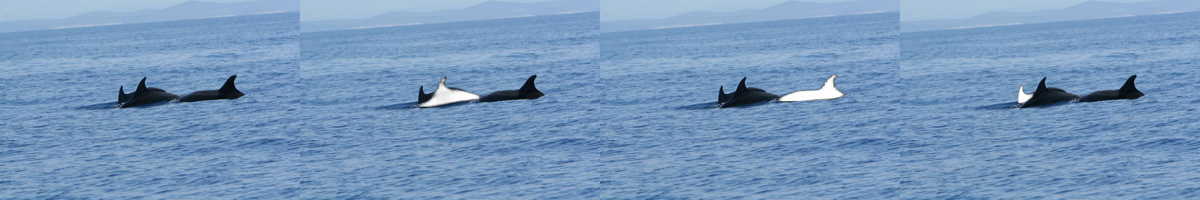

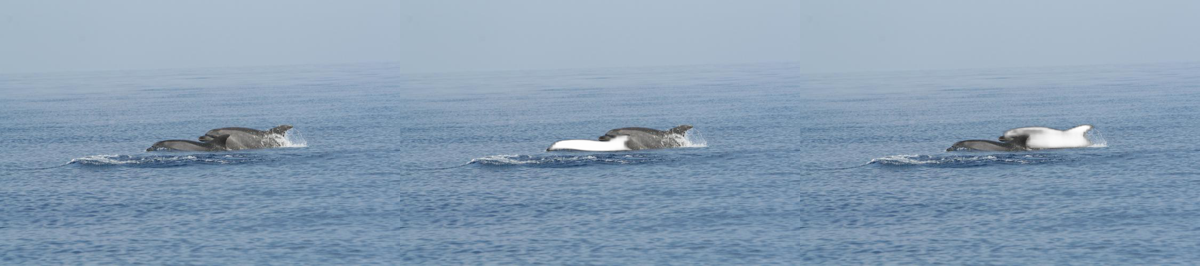

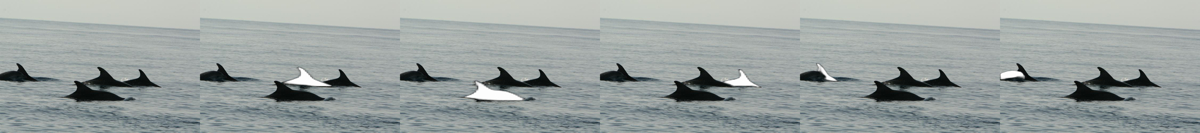

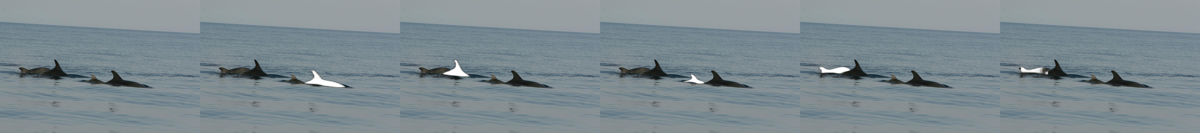

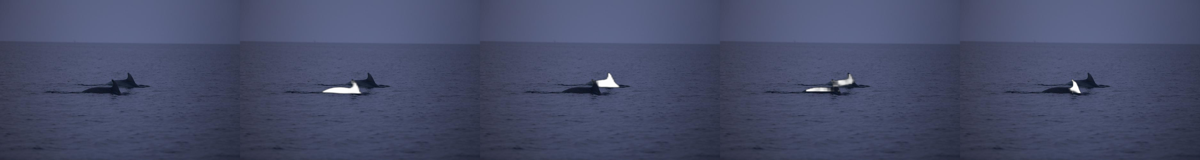

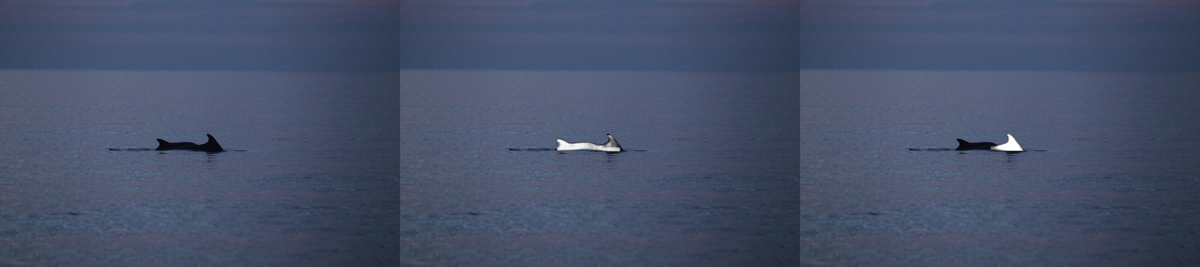

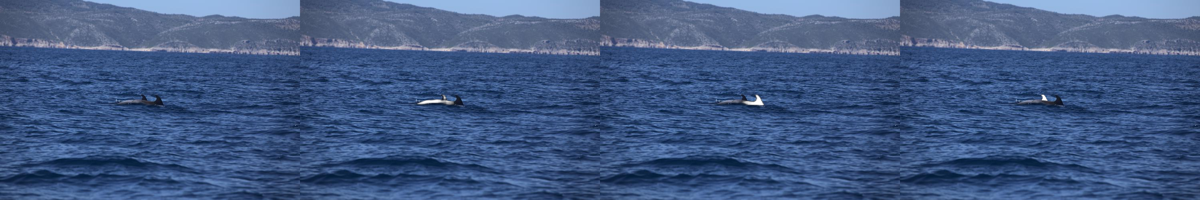

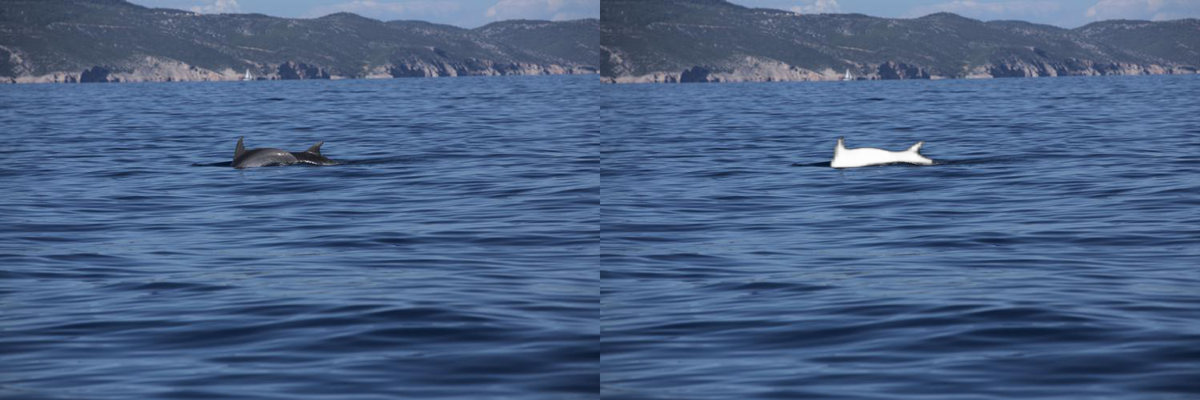

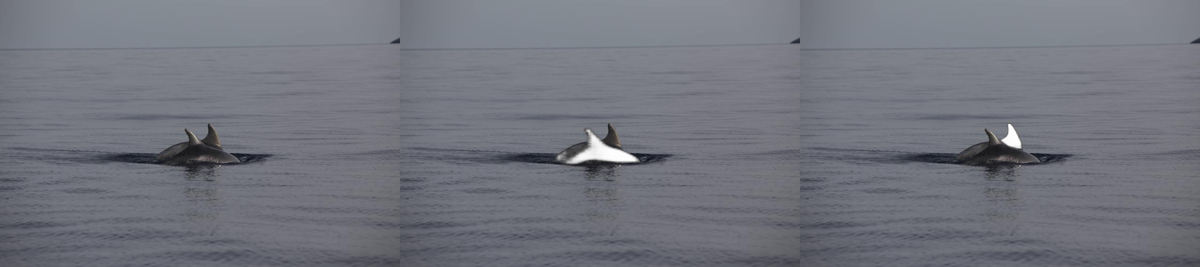

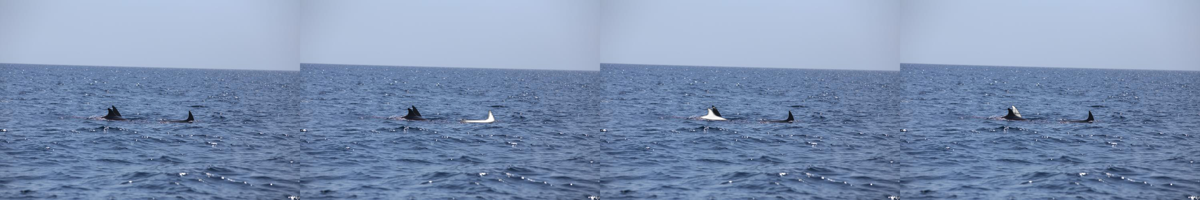

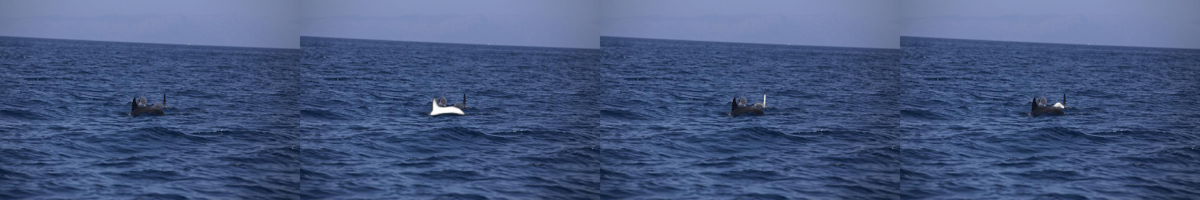

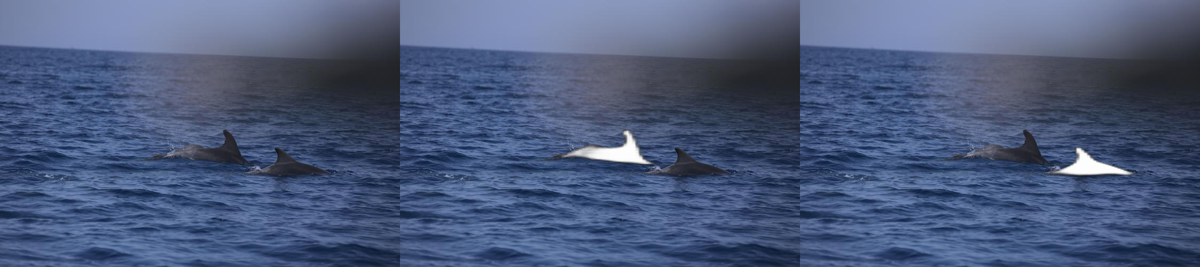

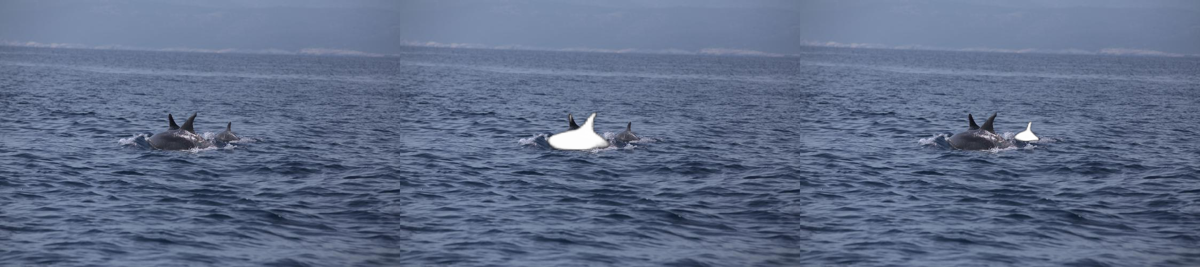

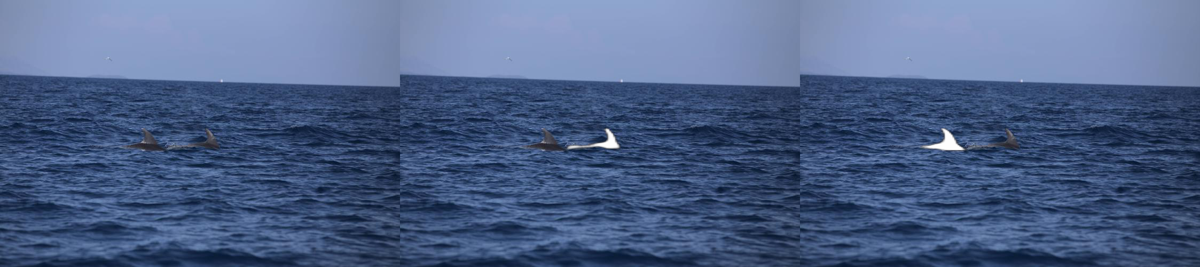

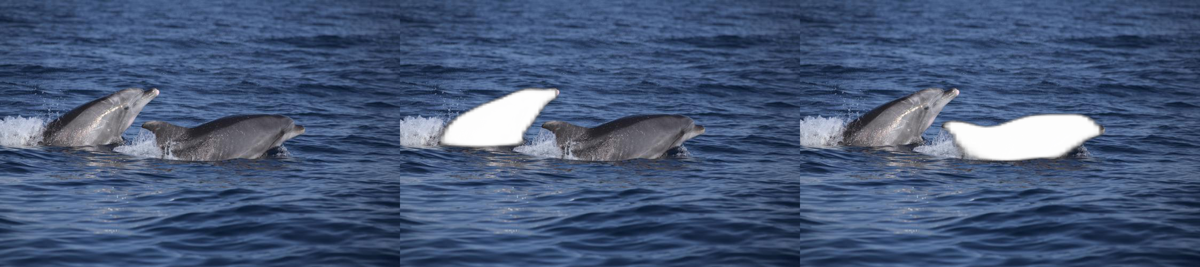

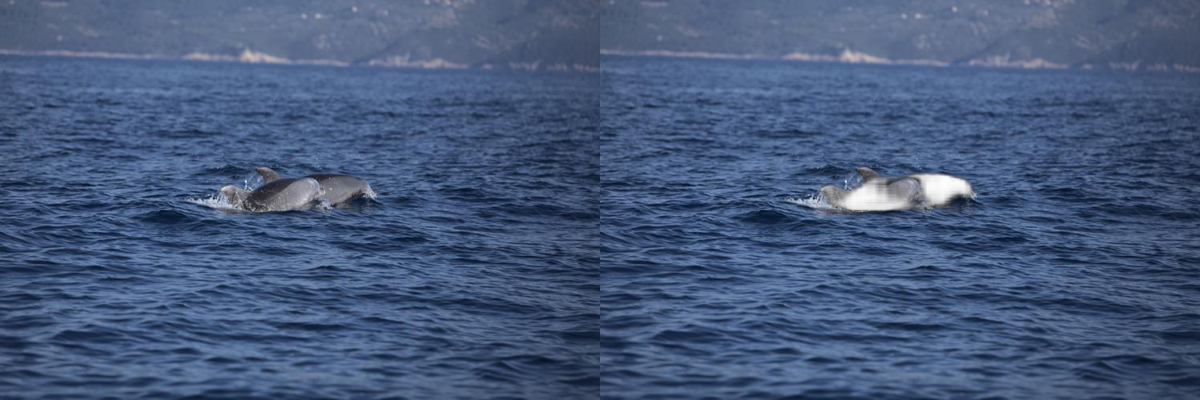

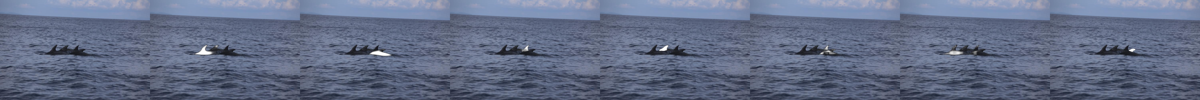

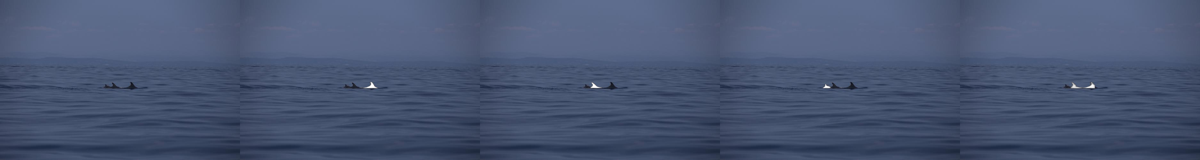

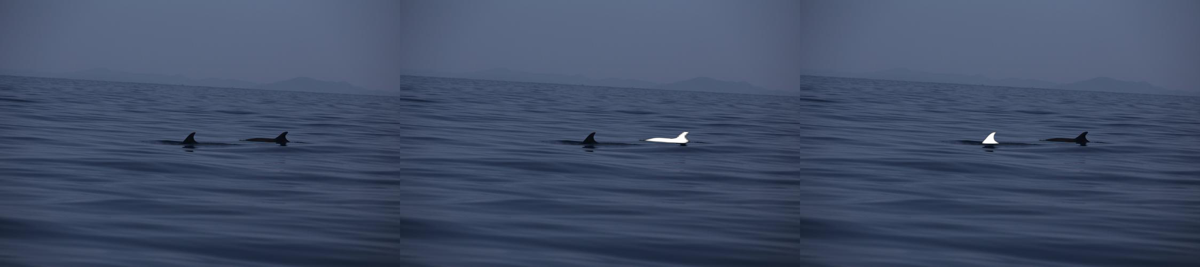

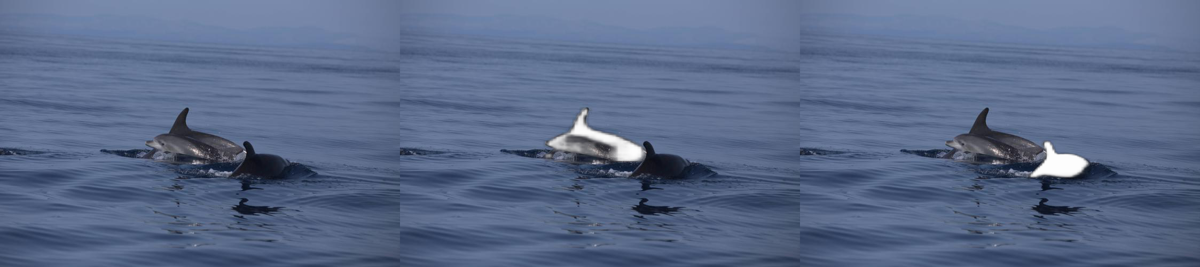

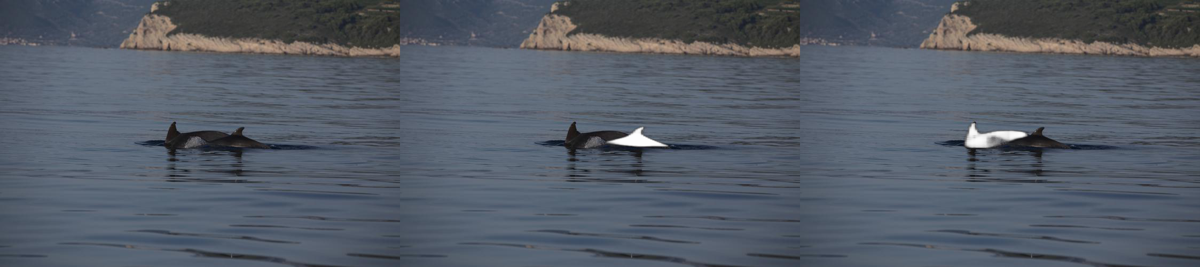

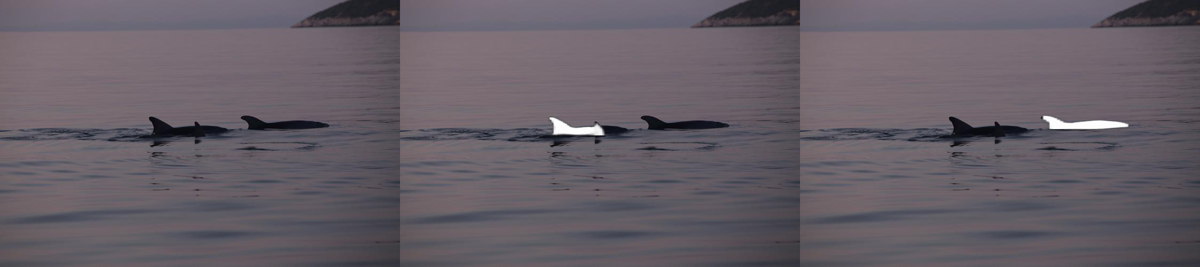

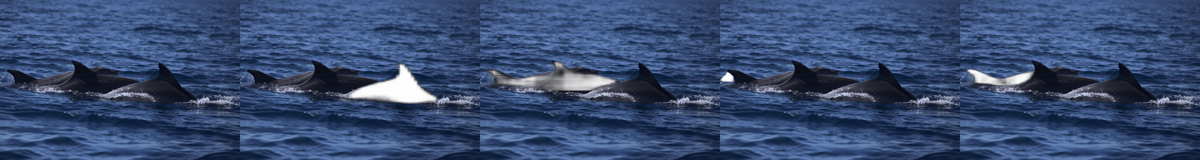

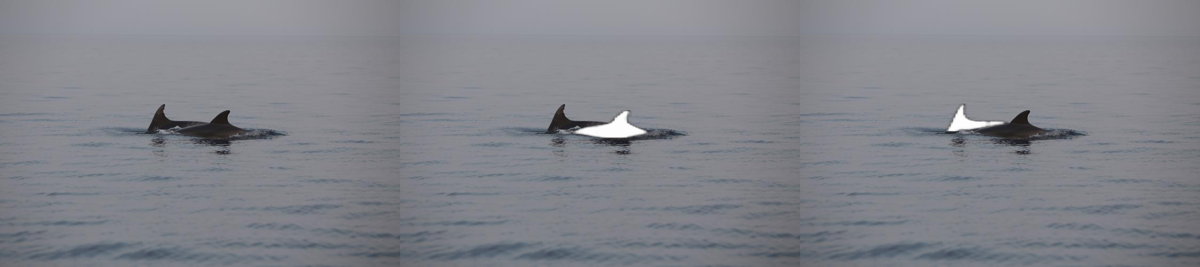

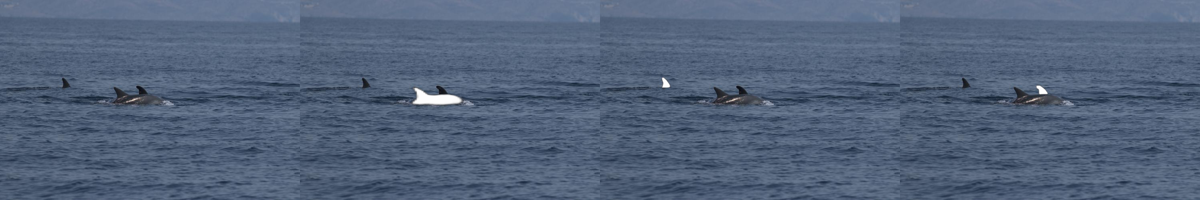

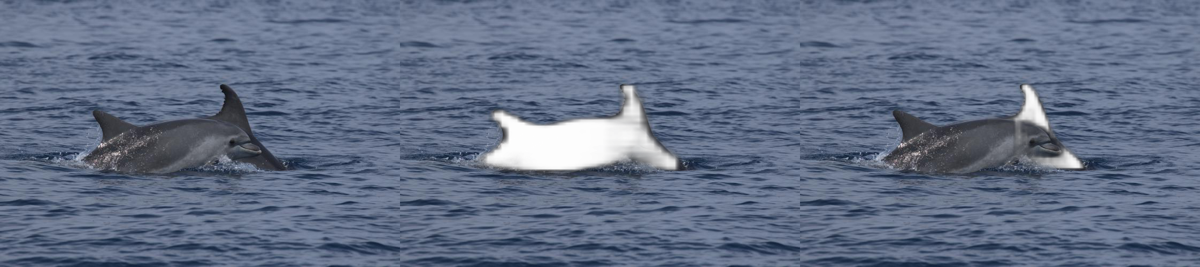

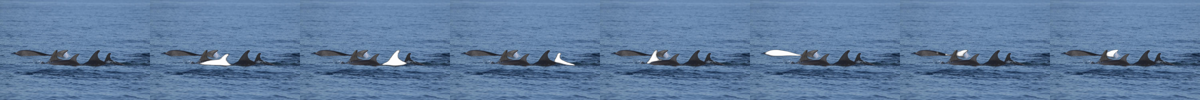

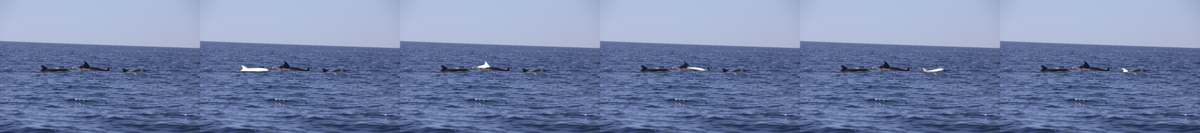

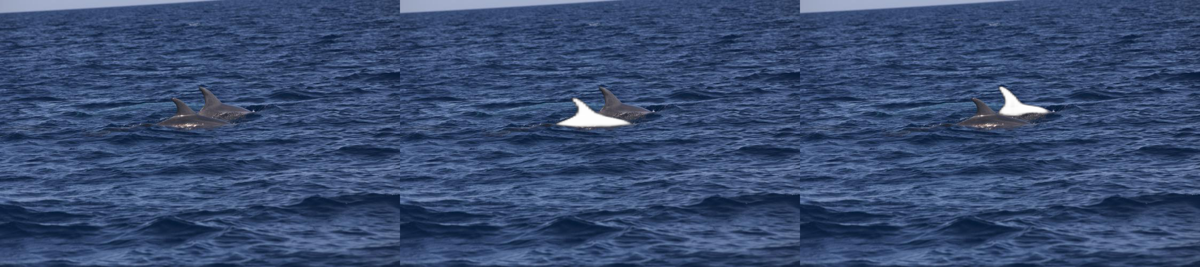

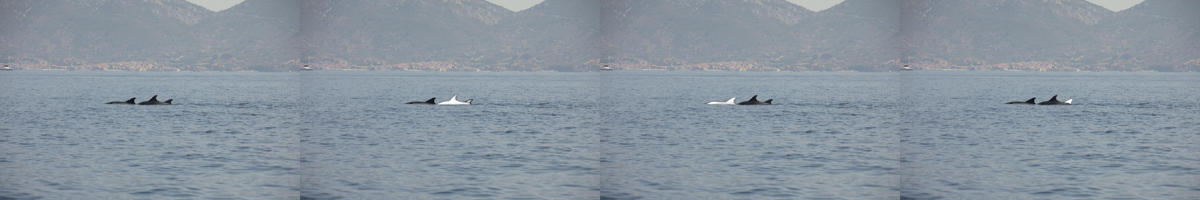

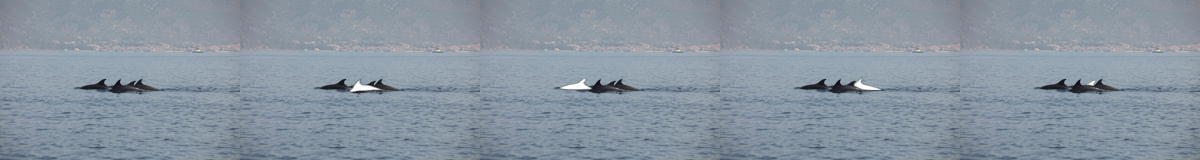

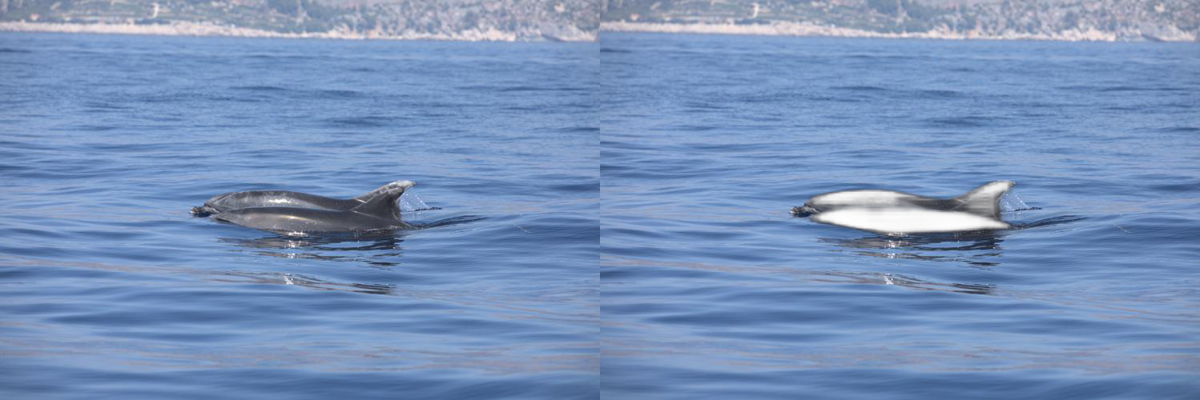

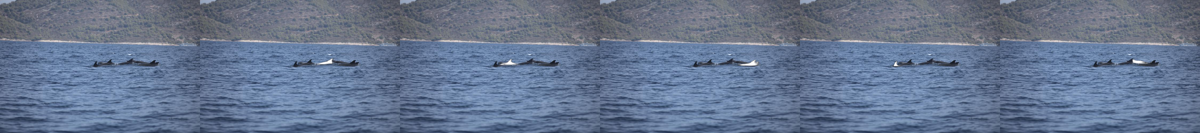

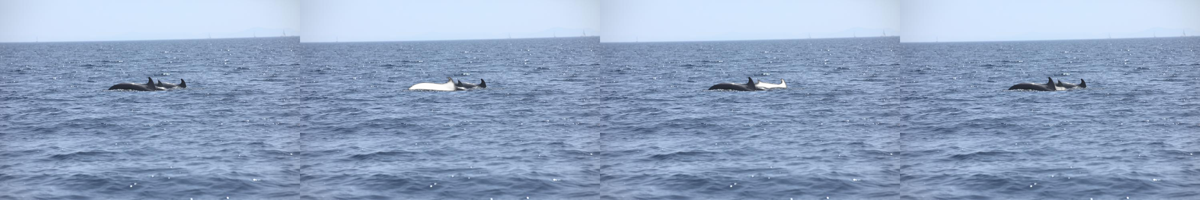

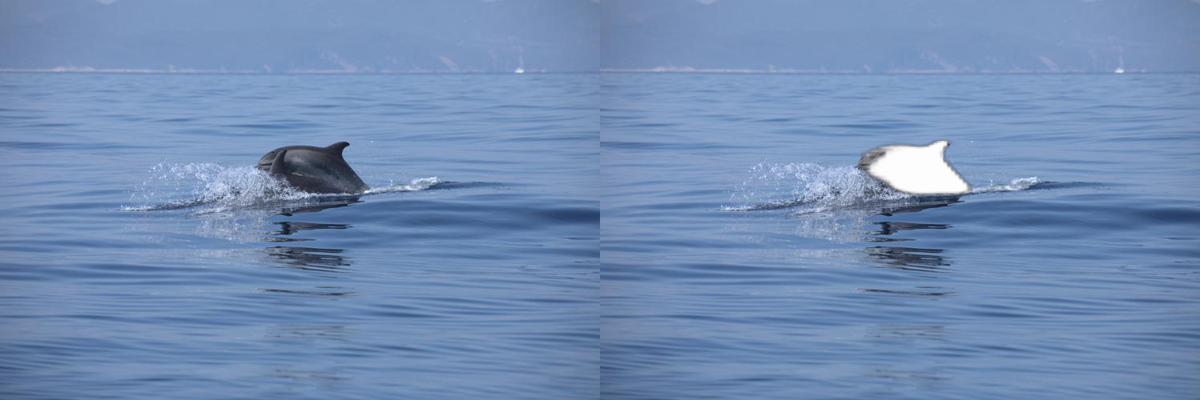

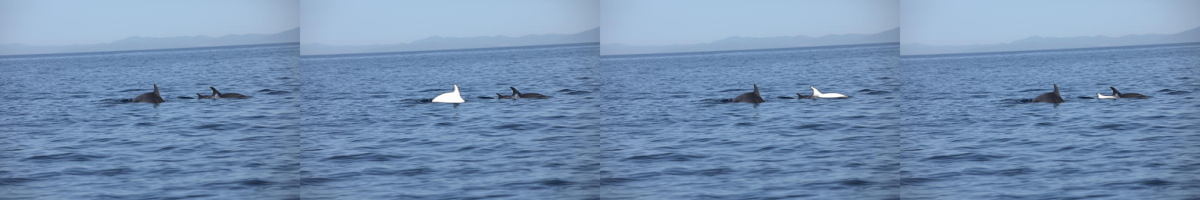

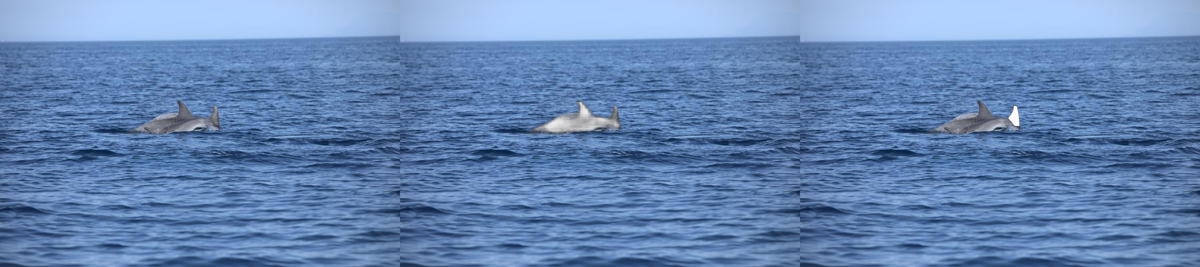

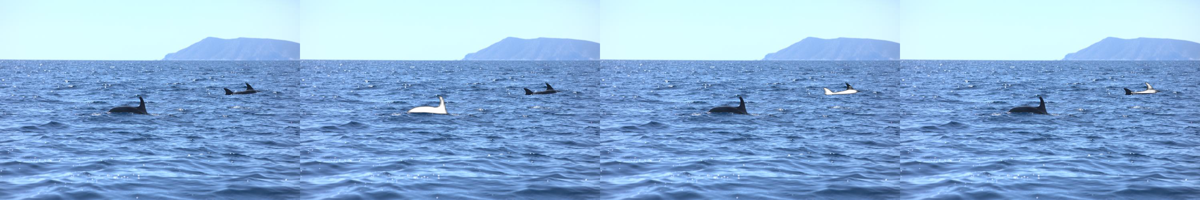

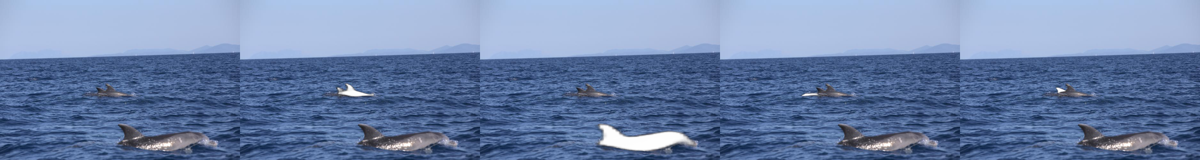

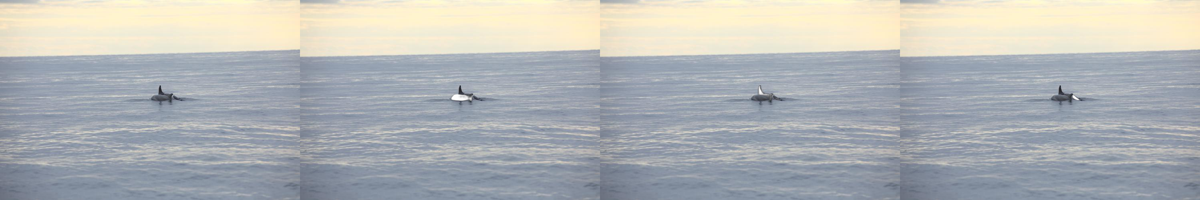

In [ ]:
from dolphins_recognition_challenge.datasets import stack_imgs

def show_pred(dl, n=None, score_limit=0.5, width=600):
    dataset_test = dl.dataset
    if n == None:
        n = len(dataset_test)

    for i in range(n):
        img = dataset_test[i][0]
        img_bg = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
        images = [img_bg]
        model.eval()
        with torch.no_grad():
            prediction = model([img.to(device)])
        predicted_masks = prediction[0]["masks"]
        scores = prediction[0]["scores"]

        for i in range(predicted_masks.shape[0]):
            score = scores[i]
            if score >= score_limit:
                bg = img_bg.copy()
                fg = Image.fromarray(predicted_masks[i, 0].mul(255).byte().cpu().numpy())
                bg.paste(fg.convert("RGB"), (0, 0), fg)
                images.append(bg)
        
        display(stack_imgs(images, width))


show_pred(data_loader_test, score_limit=0.5, width=1200)

In [ ]:
def _save_model_with_timestamp(
    model, save_path="/work/data/dupini/processed/body_100_resized/"
):
    save_date_path = (
        save_path + "model" + datetime.now().strftime("-%Y-%m-%d-%H-%M-%S") + ".pt"
    )
    print(save_date_path)
    torch.save(model.state_dict(), save_date_path)

In [ ]:
# _save_model_with_timestamp(model)

## Calculate metrics